In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, SimpleRNN, Dropout
from sklearn.metrics import mean_squared_error, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt

# Load the datasets
train_data = pd.read_csv('/content/drive/MyDrive/DL A3/archive/Google_Stock_Price_Test.csv')
test_data = pd.read_csv('/content/drive/MyDrive/DL A3/archive/Google_Stock_Price_Test.csv')

# Prepare the data
scaler = MinMaxScaler(feature_range=(0, 1))
features = ['Open', 'High', 'Low', 'Close', 'Volume']
train_data["Volume"] = train_data["Volume"].str.replace(",", "").astype(float)
test_data["Volume"] = test_data["Volume"].str.replace(",", "").astype(float)

training_set = train_data[features].values
test_set = test_data[features].values

# Scale the data
scaler = MinMaxScaler()
training_set_scaled = scaler.fit_transform(training_set)

total_data = np.concatenate((training_set, test_set), axis=0)
total_data_scaled = scaler.fit_transform(total_data)



In [ ]:
def create_dataset(data, look_back=5, predict_days=1):
  if len(data) <= look_back + predict_days:
    raise ValueError(f"Dataset size {len(data)} is too small for the specified look_back {look_back} and predict_days {predict_days}.")
  X, y = [], []
  for i in range(look_back, len(data) - predict_days + 1):
    X.append(data[i-look_back:i, :])
    y.append(data[i:i+predict_days, 0])  # Predicting 'Open' price for multiple days
  return np.array(X), np.array(y)

look_back = 5
predict_days = 3
X, y = create_dataset(training_set_scaled, look_back, predict_days)

# Reshape X for RNNs
X = X.reshape(X.shape[0], X.shape[1], X.shape[2])

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply optimized hyperparameters
best_units = 512  # Increased units for richer feature representation
best_batch_size = 16  # Smaller batch size for finer gradient updates
best_epochs = 200  # Increased epochs for deeper learning
best_learning_rate = 0.00005  # Extremely low learning rate for precise optimization


# Optimizer with tuned learning rate
best_optimizer = Adam(learning_rate=best_learning_rate)

In [ ]:
# Models to compare
models = {
    "RNN": SimpleRNN,
    "GRU": GRU,
    "LSTM": LSTM
}

results = {}

for model_name, model_layer in models.items():
    # Create a new optimizer for each model to avoid variable reuse errors
    optimizer = Adam(learning_rate=best_learning_rate)

    # Build the model
    model = Sequential([
        model_layer(units=best_units, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),

        Dropout(0.4),  # Increased dropout to prevent overfitting
        model_layer(units=best_units, return_sequences=False),

        Dropout(0.4),
        Dense(units=predict_days)
    ])

    model.compile(optimizer=optimizer, loss='mean_squared_error')
    # Assign the return value of model.fit to history
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=best_epochs, batch_size=best_batch_size, verbose=1)

    # Prepare test data
    inputs = total_data_scaled[len(total_data_scaled) - len(test_set) - look_back - predict_days + 1:]
    X_test, y_test = create_dataset(inputs, look_back, predict_days)

    # Predict and evaluate
    predictions = model.predict(X_test)
    # Adjust inverse scaling to match the dimensions
    predictions = scaler.inverse_transform(np.hstack([predictions, np.zeros((predictions.shape[0], total_data.shape[1] - predictions.shape[1]))]))[:, :predict_days]
    y_test_actual = scaler.inverse_transform(np.hstack([y_test, np.zeros((y_test.shape[0], total_data.shape[1] - y_test.shape[1]))]))[:, :predict_days]
    mse = mean_squared_error(y_test_actual, predictions)

    # Calculate classification metrics for the first day of prediction
    threshold = np.median(y_test_actual[:, 0])  # Example threshold for binary classification
    y_test_binary = (y_test_actual[:, 0] > threshold).astype(int)
    predictions_binary = (predictions[:, 0] > threshold).astype(int)

    # Calculate MSE and RMSE
    mse = mean_squared_error(y_test_actual, predictions)
    rmse = sqrt(mse)

    # Store results
    results[model_name] = {
        "model": model,
        "mse": mse,
        "rmse": rmse,
        "predictions": predictions,
        "actual": y_test_actual,
        "loss": history.history['loss'], # Now history is defined
        "val_loss": history.history['val_loss'] # Now history is defined
    }

Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.3548 - val_loss: 0.2355
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.2722 - val_loss: 0.1492
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.1843 - val_loss: 0.1079
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.1953 - val_loss: 0.0992
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.2478 - val_loss: 0.1066
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.2030 - val_loss: 0.0973
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.2764 - val_loss: 0.0815
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - loss: 0.2560 - val_loss: 0.0660
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.2862 - val_loss: 0.0589
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0803 - val_loss: 0.0613
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.1589 - val_loss: 0.0686
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.1132 - val_loss: 0.0754
Ep

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.3492 - val_loss: 0.5410
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - loss: 0.3108 - val_loss: 0.5171
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.2923 - val_loss: 0.4939
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.2690 - val_loss: 0.4713
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - loss: 0.2689 - val_loss: 0.4493
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.2512 - val_loss: 0.4279
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.2278 - val_loss: 0.4070
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.2356 - val_loss: 0.3866
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.2092 - val_loss: 0.3667
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.1843 - val_loss: 0.3472
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.1829 - val_loss: 0.3283
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.1699 -

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.3441 - val_loss: 0.5618
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.3335 - val_loss: 0.5529
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.3291 - val_loss: 0.5442
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.3216 - val_loss: 0.5355
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.3167 - val_loss: 0.5269
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.3083 - val_loss: 0.5183
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.2961 - val_loss: 0.5097
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.2941 - val_loss: 0.5012
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.2859 - val_loss: 0.4926
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.2779 - val_loss: 0.4840
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.2763 - val_loss: 0.4754
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.2656 - val_loss

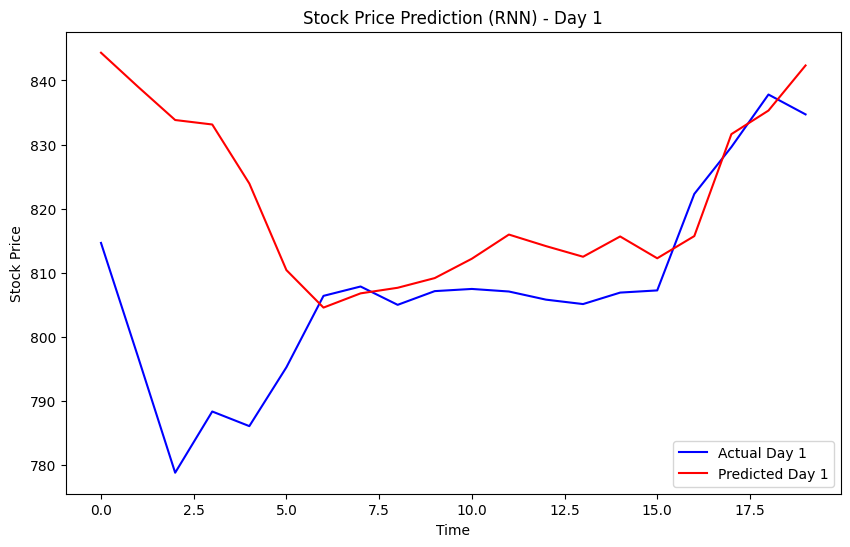

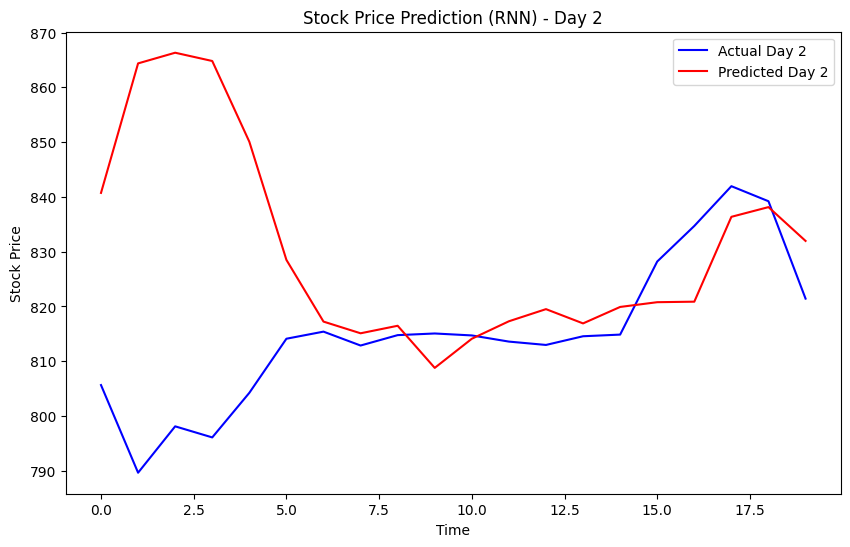

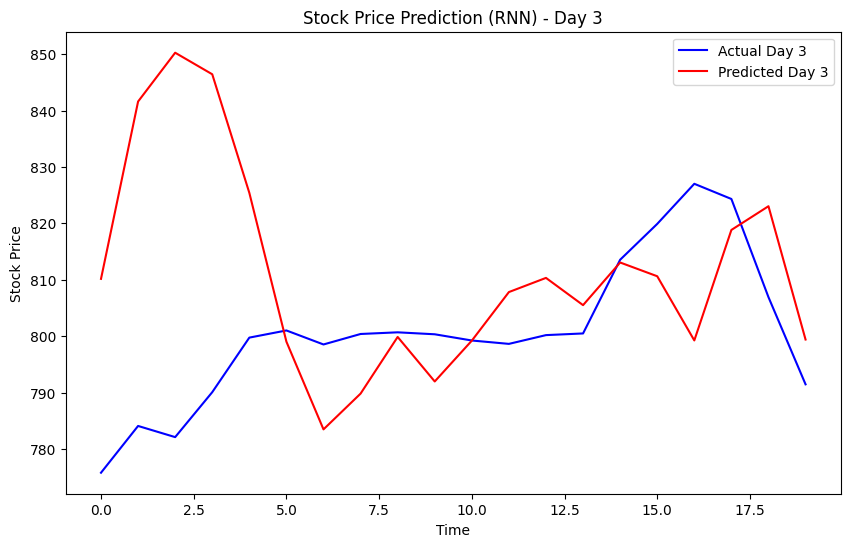

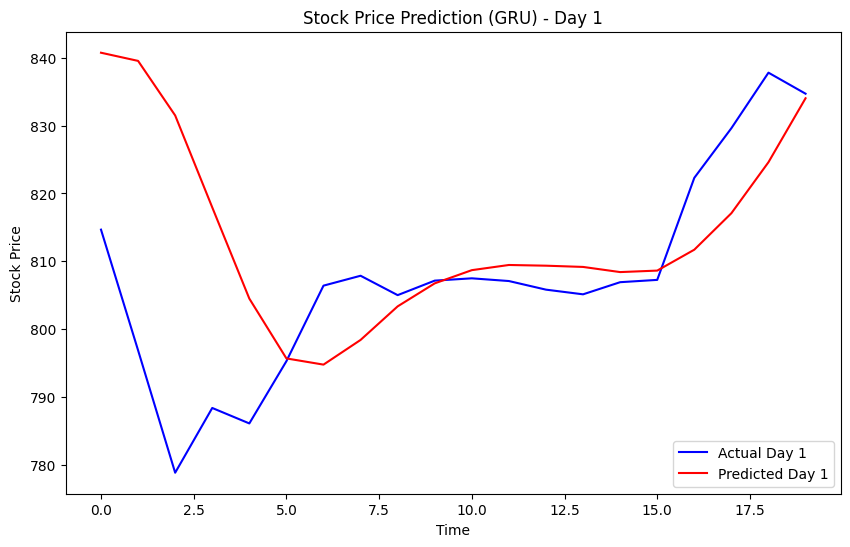

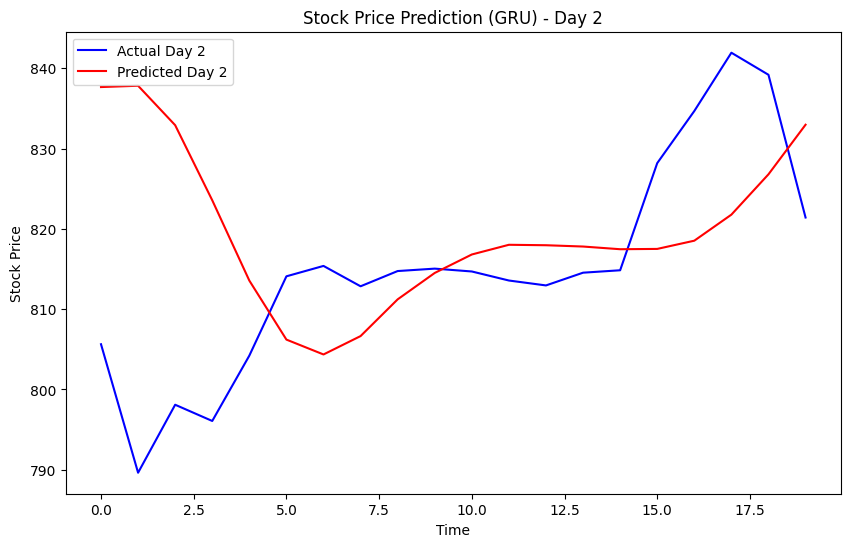

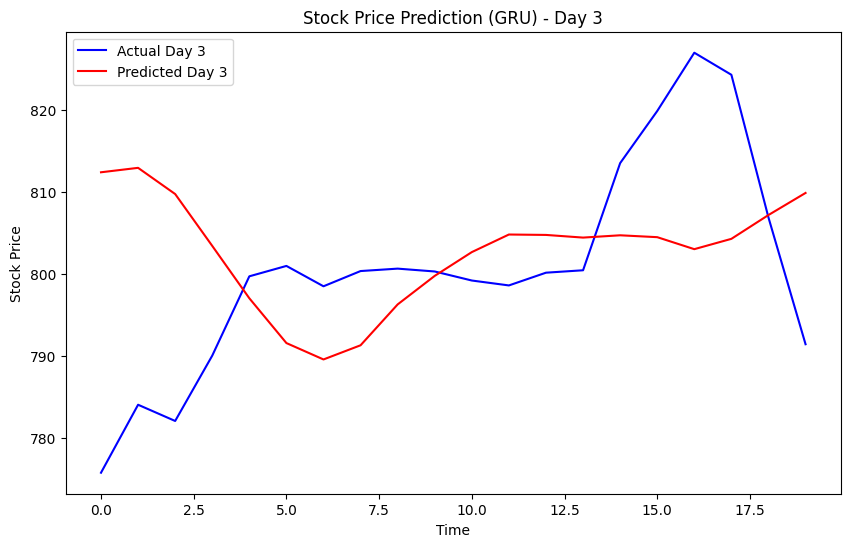

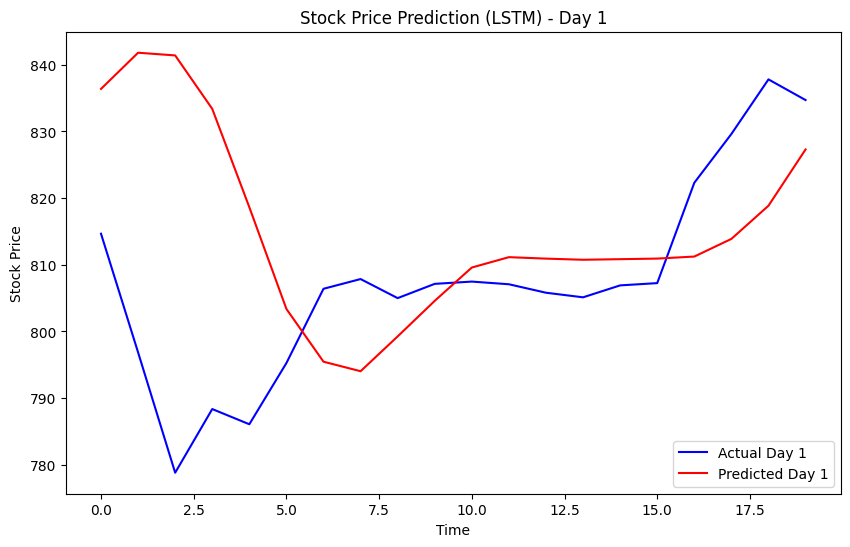

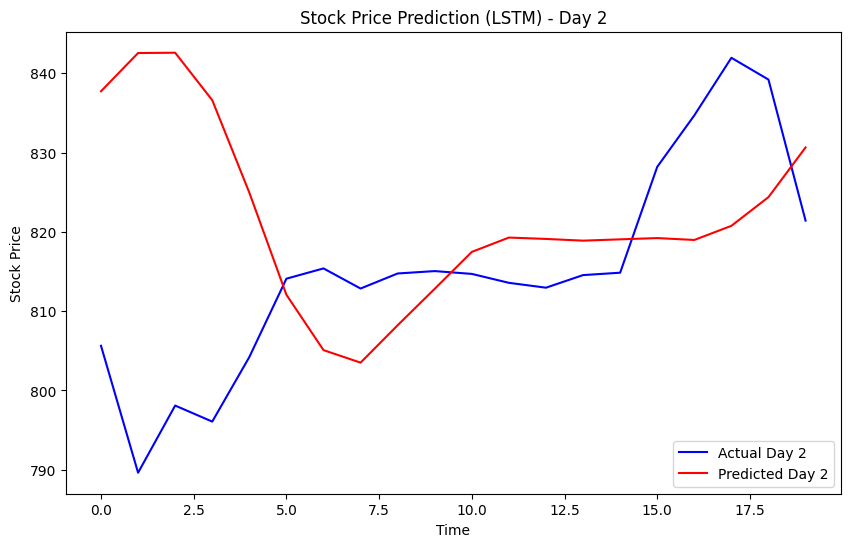

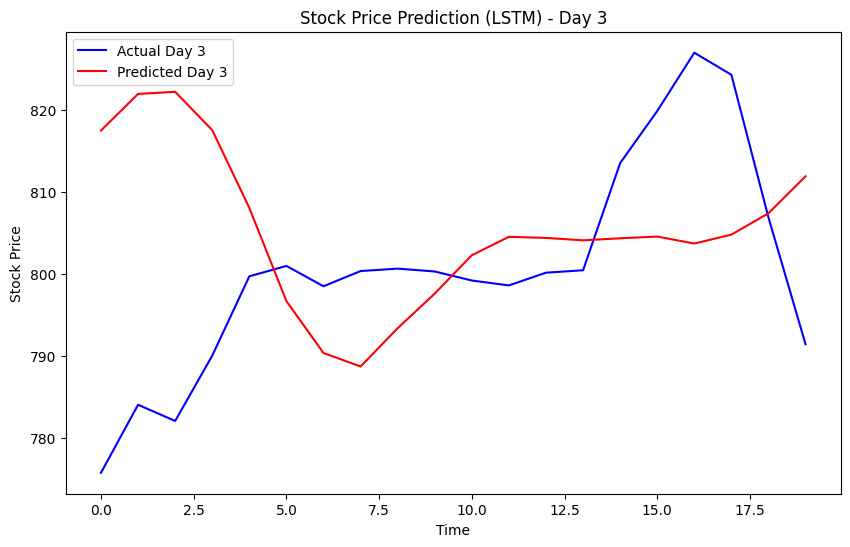

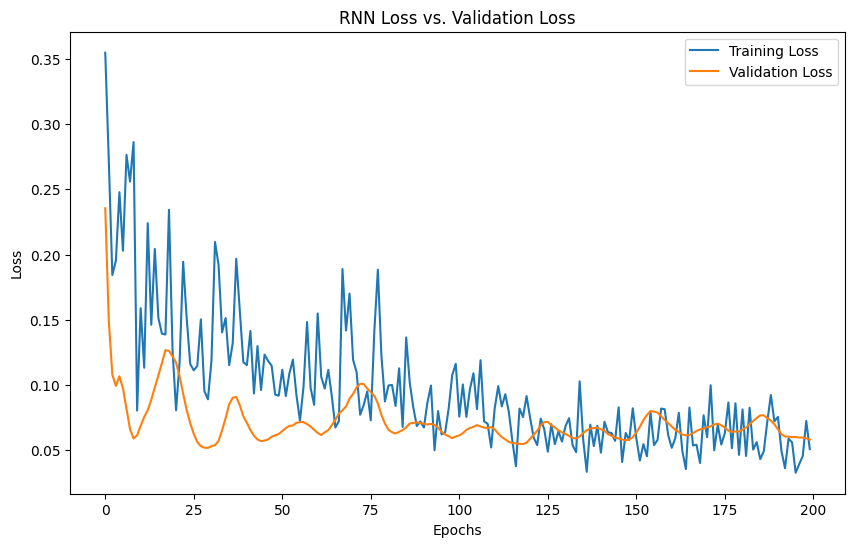

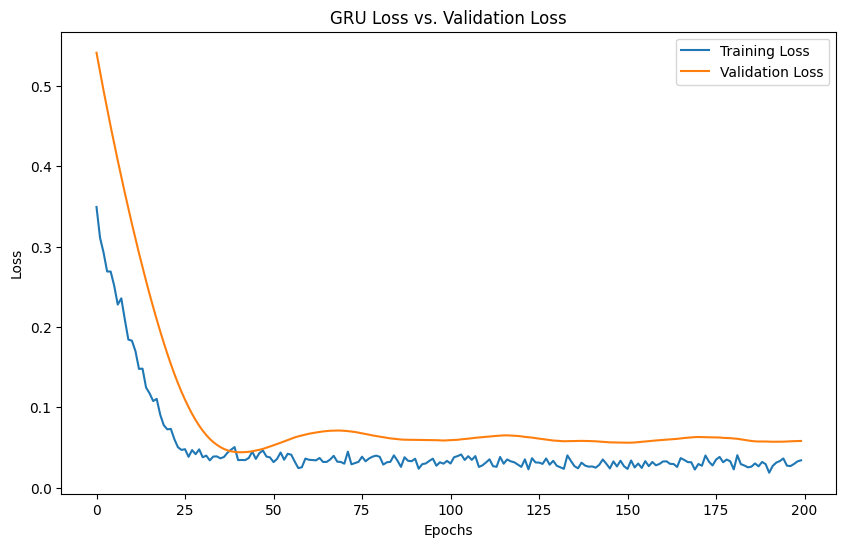

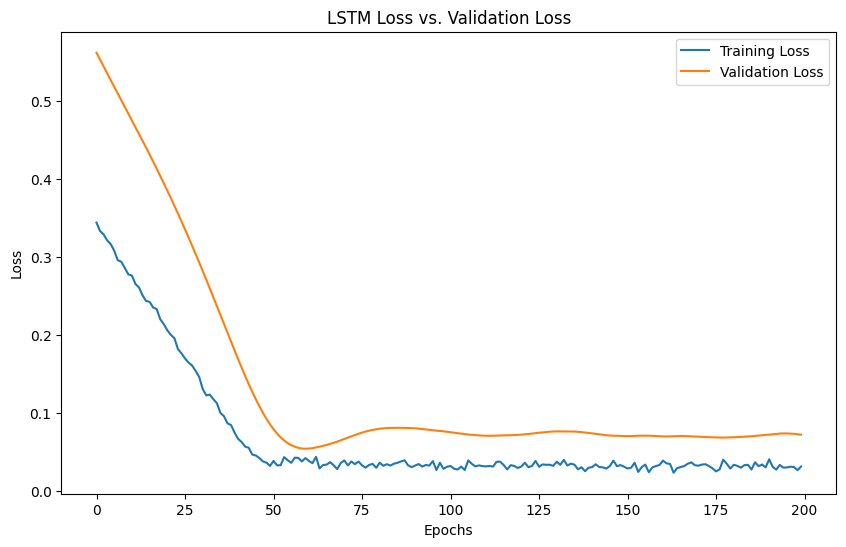

RNN Model Metrics:
RMSE: 26.97
MSE: 727.26
Final Training Loss: 0.0507
Final Validation Loss: 0.0580

GRU Model Metrics:
RMSE: 17.84
MSE: 318.27
Final Training Loss: 0.0341
Final Validation Loss: 0.0582

LSTM Model Metrics:
RMSE: 21.51
MSE: 462.62
Final Training Loss: 0.0318
Final Validation Loss: 0.0726



In [ ]:
# Plot predictions vs actuals for each model
for model_name, result in results.items():
    for i in range(predict_days):
        plt.figure(figsize=(10, 6))
        plt.plot(result["actual"][:, i], color='blue', label=f'Actual Day {i+1}')
        plt.plot(result["predictions"][:, i], color='red', label=f'Predicted Day {i+1}')
        plt.title(f'Stock Price Prediction ({model_name}) - Day {i+1}')
        plt.xlabel('Time')
        plt.ylabel('Stock Price')
        plt.legend()
        plt.show()

# Display loss and validation loss curves
for model_name, result in results.items():
    plt.figure(figsize=(10, 6))
    plt.plot(result['loss'], label='Training Loss')
    plt.plot(result['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Loss vs. Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Display MSE and RMSE for comparison
for model_name, result in results.items():
    print(f"{model_name} Model Metrics:")
    print(f"RMSE: {result['rmse']:.2f}")
    print(f"MSE: {result['mse']:.2f}")
    print(f"Final Training Loss: {result['loss'][-1]:.4f}")
    print(f"Final Validation Loss: {result['val_loss'][-1]:.4f}")
    print()